In [1]:
import cv2
import numpy as np
import torch
import datetime
from matplotlib import pyplot as plt
    
def write_video(filename, frames, width, height, fps, grayscale=False):
    if grayscale:
        writer = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*"MP4V"), fps, (width, height), 0)
    else:
        writer = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*"MP4V"), fps, (width, height))
    
    for frame in np.clip(np.around(frames), 0, 255).astype(np.uint8):
        writer.write(frame)
    writer.release()

def show_video(frames, imduration=int(1000/24.0)):
    for frame in frames:
        cv2.imshow('frame',frame)
        if cv2.waitKey(imduration) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

def reconstruction_error(frames1, frames2):
    if frames1.shape != frames2.shape:
        return -1
    return np.sqrt(np.mean((frames1 - frames2)**2))

def crit(output, gt):
    return torch.sqrt(torch.mean((output - gt)**2))

def normalize_frames(frames, **kwargs):
    mean = kwargs['mean'] if 'mean' in kwargs else np.mean(frames)
    frames = frames - mean
    std  = kwargs['std'] if 'std' in kwargs else np.std(frames)
    frames = frames / std
    
    return frames

styles = ['C'+str(c)+'-'+s for s in ['', '.', 'o', '^'] for c in [0, 1, 2, 3, 6, 8, 9] ]
def plot(x, ys, **kwargs):
    if len(ys) > len(styles):
        print('Duplicate styles')
    
    if 'fontsize' in kwargs:
        plt.rcParams.update({'font.size': kwargs['fontsize']})
    else:
        plt.rcParams.update({'font.size': 12})
        
        
    if 'figsize' in kwargs:
        plt.figure(figsize=kwargs['figsize'])
    else:
        plt.figure(figsize=(15,10))
        
    if 'xlabel' in kwargs:
        plt.xlabel(kwargs['xlabel'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])
        
    if 'yrange' in kwargs:
        low, high = kwargs['yrange']
        plt.ylim(low, high)
    
    if 'bound_to_plot' in kwargs:
        epoch, max_error = kwargs['bound_to_plot']
        ys = list(filter(lambda x: max(x[epoch:]) < max_error, ys))
        
        
    if 'labels' in kwargs:
        for i, (y, label) in enumerate(zip(ys, kwargs['labels'])):
            plt.plot(x, y, styles[i], label=label)
        plt.legend()
    else:
        for y in ys:
            plt.plot(x, y)

    if 'title' in kwargs:
        plt.title(kwargs['title'])


def sec2string(sec):
    if sec <= 60:
        return round(sec, 2)
    secr = round(sec)
    
    return str(datetime.timedelta(seconds=secr)).strip("00:")
import numpy as np # for prod
import torch
from torch import nn

class PCAAutoEncoder(nn.Module):
    def __init__(self, shape, ncomp):
        super().__init__()
        infeatures = np.prod(shape)
        self.shape = shape
        self.to_lower_rep = nn.Linear(infeatures, ncomp)
        self.from_lower_rep = nn.Linear(ncomp, infeatures)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.from_lower_rep(self.to_lower_rep(x))
        
        return x.view(x.shape[0], *self.shape)

class OneHAutoEncoder(nn.Module):
    def __init__(self, shape, ncomp, nl=nn.ReLU):
        super().__init__()
        infeatures = np.prod(shape)
        self.shape = shape
        self.ncomp = ncomp
        self.hidden_dim = 200
        self.to_lower_rep = nn.Sequential(nn.Linear(infeatures, self.hidden_dim),
                                          nl(), 
                                          nn.Linear(self.hidden_dim, ncomp))
        self.from_lower_rep = nn.Sequential(nn.Linear(ncomp, self.hidden_dim),
                                           nl(),
                                           nn.Linear(self.hidden_dim, infeatures))
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.from_lower_rep(self.to_lower_rep(x))
        
        return x.view(x.shape[0], *self.shape)
    
class SpatialConvAE(nn.Module):
    def __init__(self, inchannels, ncomp, nl=nn.ReLU, chans=[128, 128, 64]):
        super().__init__()
        self.ncomp = ncomp
        self.chans = chans
        
        self.encoder_convs = nn.Sequential(nn.Conv2d(inchannels, chans[0], kernel_size=26, stride=5), nl(), # 47
                                           nn.Conv2d(chans[0], chans[1], kernel_size=11, stride=3), nl(), # 13
                                           nn.Conv2d(chans[1], chans[2], kernel_size=6), nl()) # 8
        
        self.encoder_lin = nn.Linear(chans[2]*8*8, ncomp)
        self.decoder_lin = nn.Linear(ncomp, chans[2]*8*8)
        
        self.decoder_convs = nn.Sequential(nn.ConvTranspose2d(chans[2], chans[1], kernel_size=6), nl(),
                                           nn.ConvTranspose2d(chans[1], chans[0], kernel_size=11, stride=3), nl(),
                                           nn.ConvTranspose2d(chans[0], inchannels, kernel_size=26, stride=5))
        
        
    def forward(self, x):
        x = self.encoder_convs(x)
        x = x.view(x.shape[0], -1)
        x = self.encoder_lin(x)
        x = self.decoder_lin(x)
        x = x.view(x.shape[0], self.chans[2], 8, 8)
        x = self.decoder_convs(x)
        
        return x
    
class TemporalConvAE(nn.Module):
    def __init__(self, inchannels, nlayers, layerchans, low_dim_rep=None):
        super().__init__()
        self.inchannels = inchannels
        self.layerchans = layerchans
        c1 = c2 = c3 = c4 = c5 = layerchans
        self.low_dim_rep = low_dim_rep

        conv_params = {2: [(inchannels, c1, 8, 2),          # (1, c1, 5, 125, 125)
                           (c1, c2, (5, 7, 7), (1, 2, 2))], # (1, c2, 1, 60, 60)

                       3: [(inchannels, c1, 8, 2),          # (1, c1, 5, 125, 125)
                           (c1, c2, (3, 7, 7), (1, 2, 2)),  # (1, c2, 3, 60, 60)
                           (c2, c3, (3, 8, 8), (1, 2, 2))]  # (1, c3, 1, 27, 27)
        }

        encoder_modules = []
        for params in conv_params[nlayers]:
            encoder_modules.append(nn.Conv3d(params[0], params[1], kernel_size=params[2], stride=params[3]))
            encoder_modules.append(nn.ReLU())
        self.encoder_convs = nn.Sequential(*encoder_modules)
        self.end_shape = (c2, 1, 60, 60) if nlayers==2 else (c3, 1, 27, 27)
        if self.low_dim_rep is not None:
          self.low_dim_mapping = nn.Sequential(nn.Linear(np.prod(self.end_shape), self.low_dim_rep), 
                                               nn.Linear(self.low_dim_rep, np.prod(self.end_shape)))

        decoder_modules = []
        for params in conv_params[nlayers][::-1]:
            decoder_modules.append(nn.ConvTranspose3d(params[1], params[0], kernel_size=params[2], stride=params[3]))
            decoder_modules.append(nn.ReLU())
        self.decoder_convs = nn.Sequential(*decoder_modules)
        
    def forward(self, x):
        x = self.encoder_convs(x)
        if self.low_dim_rep is not None:
          x = self.low_dim_mapping(x.view(x.shape[0], -1)).view(-1, *self.end_shape)
        x = self.decoder_convs(x)
        
        return x

class TemporalConvAE2(nn.Module):
    def __init__(self, inchannels, nlayers, layerchans, hidden_dim):
        super().__init__()
        self.inchannels = inchannels
        self.layerchans = layerchans
        c1 = c2 = c3 = c4 = c5 = layerchans

        conv_params = {2: [(inchannels, c1, 8, 2),          # (1, c1, 5, 125, 125)
                           (c1, c2, (5, 7, 7), (1, 2, 2))], # (1, c2, 1, 60, 60)

                       3: [(inchannels, c1, 8, 2),          # (1, c1, 5, 125, 125)
                           (c1, c2, (3, 7, 7), (1, 2, 2)),  # (1, c2, 3, 60, 60)
                           (c2, c3, (3, 8, 8), (1, 2, 2))]  # (1, c3, 1, 27, 27)
        }

        encoder_modules = []
        for params in conv_params[nlayers]:
            encoder_modules.append(nn.Conv3d(params[0], params[1], kernel_size=params[2], stride=params[3]))
            encoder_modules.append(nn.ReLU())
        self.encoder_convs = nn.Sequential(*encoder_modules)
        self.end_shape = (c2, 1, 60, 60) if nlayers==2 else (c3, 1, 27, 27)
        self.encoder_lin = nn.Sequential(nn.Linear(np.prod(self.end_shape), 2*hidden_dim),
                                         nn.Linear(2*hidden_dim, hidden_dim))

        decoder_modules = []
        for params in conv_params[nlayers][::-1]:
            decoder_modules.append(nn.ConvTranspose3d(params[1], params[0], kernel_size=params[2], stride=params[3]))
            decoder_modules.append(nn.ReLU())
        self.decoder_convs = nn.Sequential(*decoder_modules)
        self.decoder_lin   = nn.Sequential(nn.Linear(hidden_dim, 2*hidden_dim),
                                           nn.Linear(2*hidden_dim, np.prod(self.end_shape)))

    def forward(self, x):
        x = self.encoder_convs(x)
        x = self.encoder_lin(x.view(x.shape[0], -1))
        
        x = self.decoder_lin(x)
        x = x.view(-1, *self.end_shape)
        x = self.decoder_convs(x)
        
        return x

    def transform(self, x):
        x = self.encoder_convs(x)
        x = self.encoder_lin(x.view(x.shape[0], -1))
        
        return x
    
    def inverse_transform(self, x):
        x = self.decoder_lin(x).view(-1, *self.end_shape)
        x = self.decoder_convs(x)
        
        return x

import numpy as np
import torch
import cv2

class VideoLoader:
    def __init__(self, filename, duration=np.inf, batch_size=64, gray=False, scale=None, skip_frame=0, randit=False, torch=True, stride=None):
        self.filename = filename
        self.gray = gray
        self.batch_size = batch_size
        cap = cv2.VideoCapture(filename)
        self.total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = round(cap.get(cv2.CAP_PROP_FPS))
        self.duration_frames = min(self.total_frames, np.ceil(duration*self.fps/batch_size)*batch_size)
        self.duration = self.duration_frames/self.fps
        self.width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        if scale:
            self.scale = True
            self.original_width  = self.width
            self.original_height = self.height
            self.width, self.height = scale
        else:
            self.scale = False
        self.skip_frame = skip_frame
        self.randit = randit
        self.torch = torch
        if stride is None:
            stride = batch_size
        else:
            if int(self.batch_size) % stride != 0:
                raise Exception("The stride must be a divisor of the batch size.")
        self.iterator_stride = stride
        
    def reduce_latent(self, model, trans=True):
        self.randit = self.skip_frame = 0
        
        reconstructed_frames = []
        for frames in self:
            # WILL ALWAYS BE TRANSFORM -> INV_TRANSFORM
            if trans:
                if self.torch:
                    reconstructed_frames.append(model.inverse_transform(*model.transform(frames)).detach())
                else:
                    reconstructed_frames.append(model.inverse_transform(*model.transform(frames)))
            else:
                reconstructed_frames.append(model(frames).detach())

        if self.torch:
            reconstructed_frames = torch.cat(reconstructed_frames, 0)
        else:
            reconstructed_frames = np.vstack(reconstructed_frames)
        return reconstructed_frames
        
    def get_all_frames(self):
        frames = []
        cap = cv2.VideoCapture(self.filename)
        current_frame = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if current_frame >= self.duration_frames:
                cap.release()
                break
            if ret:
                frames.append(self.frame_transform(frame))
                current_frame += 1
            else:
                cap.release()
        
        return self.__from_frame_list(frames)
    
    def get_random_frames(self, frames_ratio, seed=42):
        nframes = int(self.duration_frames * frames_ratio)
        frames = []
        cap = cv2.VideoCapture(self.filename)
        np.random.seed(seed)
        frame_ids = np.random.choice(np.arange(self.duration_frames), 
                                     size=nframes, 
                                     replace=False, )
        while cap.isOpened():
            ret, frame = cap.read()
            current_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
            if ret:
                if current_frame in frame_ids:
                    frames.append(self.frame_transform(frame))
            else:
                cap.release()
        
        return self.__from_frame_list(frames)
            

    def frame_transform(self, frame):
        if self.scale:
            frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        if self.gray:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
        return frame
    
    def __from_frame_list(self, frames):
        if self.torch:
            frames = torch.FloatTensor(frames)
            if self.gray:
                frames = frames.unsqueeze(1)
            else:
                frames = frames.permute((0, 3, 1, 2))
        else:
            frames = np.array(frames)
            if not self.gray:
                frames = np.transpose(frames, axes=(0,3, 1, 2))
        
        return frames
    
    def __iter__(self):
        self.__cap = cv2.VideoCapture(self.filename)
        self.__frame_count = 0
        self.__frame_order = np.arange(1, self.duration_frames+1)
        if self.randit:
            np.random.shuffle(self.__frame_order)
        self.__frame_order = iter(self.__frame_order)
        self.last_frames = []
        self.__stop = False
        return self

    def __next__(self):
        if self.__stop:
            raise StopIteration()
        
        frames = self.last_frames[self.iterator_stride:]
        while self.__cap.isOpened():
            try:
                next_frame = next(self.__frame_order)
                self.__cap.set(cv2.CAP_PROP_POS_FRAMES, next_frame - 1)
                for _ in range(self.skip_frame):
                    next(self.__frame_order)
            except StopIteration:
                self.__stop = True
                break
            ret, frame = self.__cap.read()
                
            if ret:
                frames.append(self.frame_transform(frame))
                self.__frame_count += 1
            else:
                self.__cap.release()
                self.__stop = True
                break
            
            if len(frames) % self.batch_size == 0:
                break

        self.last_frames = frames
        if self.__frame_count*(self.skip_frame+1) >= self.duration_frames:
            self.__stop = True
            
        return self.__from_frame_list(frames)
    
    def write(self, filename):
        last_torch = self.torch
        self.torch = False
        
        if self.gray:
            writer = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*"MP4V"), self.fps, (self.width, self.height), 0)
        else:
            writer = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*"MP4V"), self.fps, (self.width, self.height))
    
        cap = cv2.VideoCapture(self.filename)
        current_frame = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if current_frame >= self.duration_frames:
                cap.release()
                break
            if ret:
                #print(frame.shape)
                frame = self.frame_transform(frame)
                #print(frame.shape)
                writer.write(frame)
                current_frame += 1
            else:
                cap.release()
        
        writer.release()
        self.torch = last_torch
        
import numpy as np
from sklearn.utils.extmath import randomized_svd

class custom_pca():
    def __init__(self, ncomp=10):
        self.ncomp = ncomp
        
    def fit(self, frames):
        self.mean = np.mean(frames)
        self.std = np.std(frames)
        frames = (frames - self.mean) / self.std
        frames = frames.reshape(frames.shape[0], -1)
        self.pc, _, _ = randomized_svd(frames.T, self.ncomp)
        
    def transform(self, frames):
        shape = frames.shape[1:]
        if len(shape) > 1:
            frames = frames.reshape(frames.shape[0], -1)
        frames = (frames - self.mean) / self.std
        frames_reduced = self.pc.T @ frames.T
        
        return frames_reduced.T, shape
        
    def inverse_transform(self, frames, shape=None, cast=True):
        nframes = frames.shape[0]
        frames_reconstructed = (self.pc @ frames.T).T
        frames_reconstructed = (frames_reconstructed * self.std) + self.mean
        
        if cast:
            frames_reconstructed = np.clip(frames_reconstructed, 0, 255).astype(np.uint8)
        if shape:
            frames_reconstructed = frames_reconstructed.reshape(nframes, *shape)
        
        return frames_reconstructed

In [2]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import cv2
import torch
import torch.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep


seed = 42

### New temporal evalutation

In [ ]:
bs = 16
video = VideoLoader('R25_gray_scaled.mp4', duration=30, gray=True, batch_size=bs*4)
num_epoch, num_epoch_tune = 40, 10
iteration_per_epoch = int(video.duration_frames/video.batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

all_losses = {}
lrs = [1e-4, 5e-4, 1e-3, 5e-3]

for nlayers in [2]:
    for layerchans in [32]:
        total_time_start = time()
        print(f'Model with {nlayers} layer with {layerchans} channels:')

        losses_tune = []
        for lr in lrs:
            torch.manual_seed(seed)
            np.random.seed(seed)
            model = TemporalConvAE(1, nlayers, layerchans).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            for epoch in range(num_epoch_tune):
                epoch_loss = 0
                for frames in video:
                    frames = frames.view(-1, 1, bs, video.height, video.width).to(device)
                    reconstructed = model(frames)
                    loss = crit(frames, reconstructed)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
            losses_tune.append(epoch_loss / iteration_per_epoch)
        lr = lrs[np.argmin(losses_tune)]
        print('Chosen learning rate:', lr)
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = TemporalConvAE(1, nlayers, layerchans).to(device)
        optimizer = Adam(model.parameters(), lr=lr)

        t1 = time()
        losses = []
        for epoch in range(num_epoch):
            epoch_loss = 0
            for frames in video:
                frames = frames.view(-1, 1, video.batch_size, video.height, video.width).to(device)
                reconstructed = model(frames)
                loss = crit(frames, reconstructed)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            losses.append(epoch_loss / iteration_per_epoch)
            if (epoch+1) % 3 == 0:
                print(f'\t Error at epoch {epoch+1}:', losses[-1])
        all_losses[f'{nlayers},{layerchans}'] = ((time()-t1)/num_epoch, losses)
        print('Total time for model:', sec2string(time()-total_time_start))

print(all_losses)

Using device cuda
Tesla T4
Model with 2 layer with 32 channels:
Chosen learning rate: 0.0005
	 Error at epoch 3: 54.48595352172852
	 Error at epoch 6: 24.991223017374676
	 Error at epoch 9: 19.89936701456706
	 Error at epoch 12: 18.901718393961588
	 Error at epoch 15: 15.925000317891438
	 Error at epoch 18: 14.848928070068359
	 Error at epoch 21: 13.795453198750813
	 Error at epoch 24: 16.176995086669923
	 Error at epoch 27: 12.935467465718586
	 Error at epoch 30: 12.684498914082845
	 Error at epoch 33: 12.59496332804362
	 Error at epoch 36: 22.075228118896483
	 Error at epoch 39: 11.115845870971679
Total time for model: 18:32
{'2,32': (16.423647463321686, [100.2688501993815, 72.16681569417318, 54.48595352172852, 37.27139409383138, 29.564540481567384, 24.991223017374676, 22.930236434936525, 21.485690053304037, 19.89936701456706, 22.110327402750652, 19.297947311401366, 18.901718393961588, 17.46220219930013, 17.70987720489502, 15.925000317891438, 15.203575897216798, 14.509680684407552, 1

In [12]:
all_losses_no_low_rep = {"None": v for k, v in {"2,32": [16.423647463321686, [100.2688501993815, 72.16681569417318, 54.48595352172852, 37.27139409383138, 29.564540481567384, 24.991223017374676, 22.930236434936525, 21.485690053304037, 19.89936701456706, 22.110327402750652, 19.297947311401366, 18.901718393961588, 17.46220219930013, 17.70987720489502, 15.925000317891438, 15.203575897216798, 14.509680684407552, 14.848928070068359, 14.618293952941894, 14.721026674906414, 13.795453198750813, 14.549130694071453, 15.034529304504394, 16.176995086669923, 15.22607390085856, 13.37060407002767, 12.935467465718586, 12.633595911661784, 12.319507535298666, 12.684498914082845, 12.272142537434895, 12.018609301249187, 12.59496332804362, 19.135883458455403, 24.71298491160075, 22.075228118896483, 15.82608731587728, 12.444185956319172, 11.115845870971679, 10.599436887105306]]}.items()}

In [38]:
bs = 16
video = VideoLoader('R25_gray_scaled.mp4', duration=30, gray=True, batch_size=bs*4)
num_epoch, num_epoch_tune = 40, 10
iteration_per_epoch = int(video.duration_frames/video.batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

all_losses = {}
lrs = [1e-4, 5e-4, 1e-3, 5e-3]
nlayers, layerchans = 2, 32
for hdim in [10, 25, 50, 100, 200, 500]:
  total_time_start = time()
  print(f'Model with {hdim} low dimensionnal representation:')

  losses_tune = []
  for lr in lrs:
      torch.manual_seed(seed)
      np.random.seed(seed)
      model = TemporalConvAE(1, nlayers, layerchans, hdim).to(device)
      optimizer = Adam(model.parameters(), lr=lr)
      for epoch in range(num_epoch_tune):
          epoch_loss = 0
          for frames in video:
              frames = frames.view(-1, 1, bs, video.height, video.width).to(device)
              reconstructed = model(frames)
              loss = crit(frames, reconstructed)

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              epoch_loss += loss.item()
      losses_tune.append(epoch_loss / iteration_per_epoch)
  lr = lrs[np.argmin(losses_tune)]
  print('Chosen learning rate:', lr)
  torch.manual_seed(seed)
  np.random.seed(seed)
  model = TemporalConvAE(1, nlayers, layerchans, hdim).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  t1 = time()
  losses = []
  for epoch in range(num_epoch):
      epoch_loss = 0
      for frames in video:
          frames = frames.view(-1, 1, bs, video.height, video.width).to(device)
          reconstructed = model(frames)
          loss = crit(frames, reconstructed)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      losses.append(epoch_loss / iteration_per_epoch)
      if (epoch+1) % 3 == 0:
          print(f'\t Error at epoch {epoch+1}:', losses[-1])
  all_losses[f'{hdim}'] = ((time()-t1)/num_epoch, losses)
  print('Total time for model:', sec2string(time()-total_time_start))

print(json.dumps(all_losses))

Using device cuda
Tesla T4
Model with 10 low dimensionnal representation:
Chosen learning rate: 0.0005
	 Error at epoch 3: 74.31835174560547
	 Error at epoch 6: 28.623581314086913
	 Error at epoch 9: 22.4530818939209
	 Error at epoch 12: 19.86261380513509
	 Error at epoch 15: 18.75685125986735
	 Error at epoch 18: 19.540908432006837
	 Error at epoch 21: 17.360565376281738
	 Error at epoch 24: 17.70168056488037
	 Error at epoch 27: 17.182668495178223
	 Error at epoch 30: 16.400724283854167
	 Error at epoch 33: 17.390546226501463
	 Error at epoch 36: 17.249407450358074
	 Error at epoch 39: 16.771528307596842
Total time for model: 14:55
Model with 25 low dimensionnal representation:
Chosen learning rate: 0.0005
	 Error at epoch 3: 43.71887741088867
	 Error at epoch 6: 26.240281295776366
	 Error at epoch 9: 19.9189094543457
	 Error at epoch 12: 19.30657869974772
	 Error at epoch 15: 26.300433349609374
	 Error at epoch 18: 17.098693784077962
	 Error at epoch 21: 17.753202056884767
	 Error a

In [14]:
all_losses = {"10": [11.23525149822235, [157.3454121907552, 133.65197092692057, 74.31835174560547, 46.35602010091146, 34.84018821716309, 28.623581314086913, 25.53305155436198, 23.77599614461263, 22.4530818939209, 21.234851582845053, 20.92053565979004, 19.86261380513509, 19.602813148498534, 19.468173853556316, 18.75685125986735, 18.783629099527996, 18.547141075134277, 19.540908432006837, 17.783074315388998, 18.846221669514975, 17.360565376281738, 17.465984090169272, 18.793028767903646, 17.70168056488037, 17.714755376180012, 17.530144119262694, 17.182668495178223, 16.529397519429526, 16.30423666636149, 16.400724283854167, 16.529284858703612, 16.334380022684734, 17.390546226501463, 18.394114557902018, 17.60867951711019, 17.249407450358074, 17.09790147145589, 16.854215876261392, 16.771528307596842, 16.59171543121338]], "25": [11.243299984931946, [148.39895629882812, 85.04213740030924, 43.71887741088867, 31.09572105407715, 26.9146245320638, 26.240281295776366, 22.156363932291665, 20.9029483795166, 19.9189094543457, 19.625249354044595, 19.42526404062907, 19.30657869974772, 17.857105827331544, 19.455137062072755, 26.300433349609374, 29.55785566965739, 19.21101048787435, 17.098693784077962, 16.848478889465333, 16.888674290974937, 17.753202056884767, 17.788817850748696, 17.66816832224528, 17.515948740641274, 17.405528895060222, 17.321274058024088, 17.208988253275553, 17.16297105153402, 17.045553652445474, 17.028777503967284, 16.899389203389486, 16.888643646240233, 16.78755416870117, 16.717599614461264, 16.629187393188477, 16.500082397460936, 16.26253407796224, 16.23318271636963, 15.988917223612468, 16.668880526224772]], "50": [11.398413592576981, [124.9728006998698, 93.62464447021485, 67.25755208333334, 48.56924947102865, 40.1001828511556, 34.452293395996094, 30.043352381388345, 27.481174850463866, 26.079768498738606, 25.043247985839844, 24.458132807413737, 23.300649897257486, 22.00779774983724, 20.964879099527995, 20.556384658813478, 19.999108378092448, 19.503791936238606, 19.10285415649414, 18.82525914510091, 18.689400927225748, 19.735790952046713, 19.949103800455728, 18.60360450744629, 18.120472844441732, 17.517554473876952, 17.390773836771647, 17.19660129547119, 17.127079010009766, 16.929196230570476, 17.138728459676106, 17.50647741953532, 18.196594365437825, 17.766791343688965, 17.71724662780762, 16.81022357940674, 16.406612141927084, 16.274045117696126, 16.183318646748862, 16.08604227701823, 15.985837491353353]], "100": [11.372466427087783, [124.75551350911458, 86.38139038085937, 56.59128239949544, 41.611558278401695, 34.787408447265626, 30.227833557128907, 27.20180066426595, 25.84123446146647, 24.052426274617513, 22.984432729085288, 21.713283030192056, 21.225562795003256, 20.759325408935545, 19.985680898030598, 20.565431340535483, 20.421476554870605, 19.785601870218912, 18.455218760172524, 18.313581466674805, 17.86287301381429, 17.583715629577636, 17.44530455271403, 17.553257815043132, 18.462363942464194, 18.696895535786947, 17.231047248840333, 16.71972599029541, 16.69188378651937, 16.64587262471517, 16.6865790049235, 16.376340738932292, 16.655783780415852, 16.633279291788735, 16.995163345336913, 16.576720428466796, 16.59386781056722, 16.15286095937093, 16.764944330851236, 16.477834192911782, 16.802414830525716]], "200": [11.33816202878952, [157.70709940592448, 108.51539866129558, 53.75648422241211, 33.41899045308431, 27.458422088623045, 25.56618334452311, 24.351747385660808, 26.479451115926107, 35.27594362894694, 36.3174690246582, 25.23941968282064, 20.824207433064778, 19.903147570292155, 19.031722005208334, 19.007746251424155, 18.7973534266154, 18.792967160542805, 19.33326791127523, 18.507420158386232, 17.82172794342041, 17.707732836405437, 18.823085912068684, 17.794757080078124, 19.338801447550455, 17.413487561543782, 17.926230303446452, 17.106028366088868, 19.374988555908203, 31.941482671101888, 23.347738138834636, 27.48350823720296, 17.335332425435386, 16.98242645263672, 16.836187998453777, 16.527957471211753, 17.47574100494385, 17.70629825592041, 16.7478941599528, 16.324249585469563, 17.648705164591473]], "500": [11.90346313714981, [130.03892211914064, 83.88011423746745, 47.334224446614584, 34.446943537394205, 29.271479670206705, 29.319595464070638, 26.39070790608724, 24.735267130533853, 21.786799748738606, 20.946694056193035, 20.376453653971353, 19.517165756225587, 19.21904729207357, 19.105213356018066, 18.71443297068278, 18.194826634724937, 17.8807580947876, 18.755270195007324, 18.0312983194987, 17.778061230977375, 17.086693827311198, 16.854203287760416, 16.698691622416177, 16.692912356058756, 16.90221207936605, 17.65980993906657, 16.502413686116537, 18.5323460261027, 24.242139307657876, 17.120299021402996, 16.382482782999674, 16.121771367390952, 16.185231399536132, 16.159590212504067, 16.098626708984376, 16.04793898264567, 16.01759433746338, 16.00394198099772, 15.97741731007894, 15.942611567179362]]}
all_losses.update(all_losses_no_low_rep)
print(json.dumps(all_losses))

{"10": [11.23525149822235, [157.3454121907552, 133.65197092692057, 74.31835174560547, 46.35602010091146, 34.84018821716309, 28.623581314086913, 25.53305155436198, 23.77599614461263, 22.4530818939209, 21.234851582845053, 20.92053565979004, 19.86261380513509, 19.602813148498534, 19.468173853556316, 18.75685125986735, 18.783629099527996, 18.547141075134277, 19.540908432006837, 17.783074315388998, 18.846221669514975, 17.360565376281738, 17.465984090169272, 18.793028767903646, 17.70168056488037, 17.714755376180012, 17.530144119262694, 17.182668495178223, 16.529397519429526, 16.30423666636149, 16.400724283854167, 16.529284858703612, 16.334380022684734, 17.390546226501463, 18.394114557902018, 17.60867951711019, 17.249407450358074, 17.09790147145589, 16.854215876261392, 16.771528307596842, 16.59171543121338]], "25": [11.243299984931946, [148.39895629882812, 85.04213740030924, 43.71887741088867, 31.09572105407715, 26.9146245320638, 26.240281295776366, 22.156363932291665, 20.9029483795166, 19.91

### Temporal Convolutional AE 2

In [ ]:
bs = 16
video = VideoLoader('R25_gray_scaled.mp4', duration=30, gray=True, batch_size=bs, stride=int(bs/2))
num_epoch, num_epoch_tune = 30, 10
iteration_per_epoch = int(video.duration_frames/video.batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

all_losses = {}
lrs = [5e-5, 1e-4, 5e-4, 0.001]
for hdim in [25, 50]:
  for nlayers in [2, 3]:
    for layerchans in [32]:
      total_time_start = time()
      print(f'Model with {nlayers} layer with {layerchans} channels, {hdim} hidden dimension:')

      losses_tune = []
      for lr in lrs:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = TemporalConvAE2(1, nlayers, layerchans, hdim).to(device)
        optimizer = Adam(model.parameters(), lr=lr)
        for epoch in range(num_epoch_tune):
          epoch_loss = 0
          for frames in video:
            frames = frames.view(-1, 1, video.batch_size, video.height, video.width).to(device)
            reconstructed = model(frames)
            loss = crit(frames, reconstructed)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses_tune.append(epoch_loss / iteration_per_epoch)
      lr = lrs[np.argmin(losses_tune)]
      print('Chosen learning rate:', lr)
      torch.manual_seed(seed)
      np.random.seed(seed)
      model = TemporalConvAE2(1, nlayers, layerchans, hdim).to(device)
      optimizer = Adam(model.parameters(), lr=lr)

      t1 = time()
      losses = []
      for epoch in range(num_epoch):
        epoch_loss = 0
        for frames in video:
          frames = frames.view(-1, 1, video.batch_size, video.height, video.width).to(device)
          reconstructed = model(frames)
          loss = crit(frames, reconstructed)
                  
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
        losses.append(epoch_loss / iteration_per_epoch)
        if (epoch+1) % 3 == 0:
          print(f'\t Error at epoch {epoch+1}:', losses[-1])
      all_losses[f'{nlayers},{layerchans},{hdim}'] = ((time()-t1)/num_epoch, losses)
      print('Total time for model:', sec2string(time()-total_time_start))

print(json.dumps(all_losses))

Using device cuda
Tesla T4
Model with 2 layer with 32 channels, 25 hidden dimension:
Chosen learning rate: 0.0001
	 Error at epoch 3: 38.50400121588456
	 Error at epoch 6: 32.8162662439179
	 Error at epoch 9: 31.79142302797552
	 Error at epoch 12: 31.444986309921532
	 Error at epoch 15: 31.539406558923552
	 Error at epoch 18: 30.30803538205331
	 Error at epoch 21: 34.37204386058607
	 Error at epoch 24: 32.44506963094076
	 Error at epoch 27: 35.869984894468075
	 Error at epoch 30: 34.97102894699364
Total time for model: 29:2
Model with 3 layer with 32 channels, 25 hidden dimension:
Chosen learning rate: 0.0001
	 Error at epoch 3: 40.912400245666504
	 Error at epoch 6: 34.887123609844004
	 Error at epoch 9: 32.63805240497255
	 Error at epoch 12: 31.455634217513236
	 Error at epoch 15: 32.664297220999735
	 Error at epoch 18: 31.239481741921942
	 Error at epoch 21: 31.014165142126252
	 Error at epoch 24: 30.887358598541795
	 Error at epoch 27: 30.437879495453416
	 Error at epoch 30: 30.275

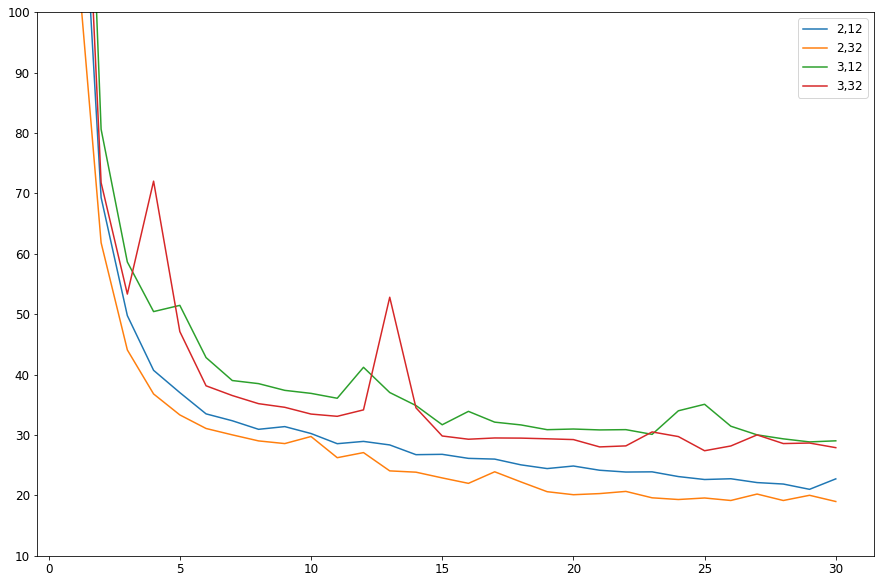

In [ ]:
all_losses = {"2,12": [7.5671628475189205, [145.9913723594264, 69.31659768757068, 49.76479399831671, 40.7097090670937, 37.02049857691715, 33.498723582217565, 32.35901847638582, 30.941754140351946, 31.390320828086452, 30.2458808798539, 28.561049561751517, 28.939566863210576, 28.355340807061445, 26.742614997060674, 26.799937449003522, 26.131655090733577, 26.009860841851484, 25.057784331472295, 24.44118178518195, 24.86541441867226, 24.16547935887387, 23.86864094985159, 23.90033541227642, 23.118441782499616, 22.63034775382594, 22.756784840633994, 22.123981526023464, 21.881161840338457, 21.0054282640156, 22.737454163400752]], "2,32": [7.783597000439962, [113.51939050774826, 61.83749590421978, 44.08352028696161, 36.79498180590178, 33.32640140934994, 31.078706791526393, 30.023011408354108, 29.023362460889313, 28.57973731191535, 29.751451693083112, 26.24220205608167, 27.0867405439678, 24.059268951416016, 23.844503101549652, 22.89506314930163, 21.994265204981755, 23.909275105125026, 22.232903982463636, 20.61334258631656, 20.113915092066716, 20.299328753822728, 20.6608617682206, 19.600247985438298, 19.319557189941406, 19.57112879502146, 19.157926559448242, 20.222982381519518, 19.15525524239791, 20.01758959418849, 18.988980594434235]], "3,12": [7.509626404444377, [193.0766655771356, 80.61528135600842, 58.64474015486868, 50.43208814922132, 51.46465211165579, 42.81823118109452, 39.018533305117955, 38.50585425527472, 37.39178868343956, 36.89295482635498, 36.082418291192305, 41.20817274796335, 37.03325015620182, 34.87848116222181, 31.69615650177002, 33.9118258827611, 32.129321349294564, 31.668499695627315, 30.8813318453337, 30.989928496511357, 30.840006225987484, 30.887052385430586, 30.104329711512516, 34.0074496520193, 35.085258734853646, 31.455778975235788, 30.024665932906302, 29.361871970327275, 28.855908695020172, 29.036713951512386]], "3,32": [7.487318229675293, [166.71528143631784, 71.76952432331287, 53.33226103531687, 72.0264919682553, 47.127410888671875, 38.144509064523795, 36.53278099863153, 35.18784794054533, 34.58617913095575, 33.466624310142116, 33.09361904545834, 34.15858012751529, 52.808086144296745, 34.500372183950326, 29.83611111891897, 29.300787624559906, 29.508590346888493, 29.48403428730212, 29.369984375803096, 29.2431126142803, 28.027923583984375, 28.197450135883532, 30.507628541243704, 29.74084020915784, 27.394746730202122, 28.18378724549946, 30.015718259309466, 28.582593968040065, 28.669011216414603, 27.904998779296875]]}
plot(np.arange(1, 31), [t[1][1] for t in all_losses.items()], labels=[t[0] for t in all_losses.items()], yrange=(10, 100))

### Temporal Convolutional AE

In [ ]:
bs = 16
video = VideoLoader('R25_gray_scaled.mp4', duration=10, gray=True, batch_size=bs)
num_epoch, num_epoch_tune = 30, 10
iteration_per_epoch = int(video.duration_frames/video.batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

all_losses = {}
lrs = {1: [5e-4, 0.001, 0.005],
       2: [5e-4, 0.001],
       3: [5e-4, 0.001],
       4: [5e-5, 1e-4, 5e-4],
       5: [1e-5, 5e-5, 1e-4, 5e-4]}
for nlayers in range(2, 3):
  for layerchans in [12, 32]:
    total_time_start = time()
    print(f'Model with {nlayers} layer with {layerchans} channels:')

    losses_tune = []
    for lr in lrs[nlayers]:
      torch.manual_seed(seed)
      np.random.seed(seed)
      model = TemporalConvAE(1, nlayers, layerchans).to(device)
      optimizer = Adam(model.parameters(), lr=lr)
      for epoch in range(num_epoch_tune):
        epoch_loss = 0
        for frames in video:
          frames = frames.view(-1, 1, video.batch_size, video.height, video.width).to(device)
          reconstructed = model(frames)
          loss = crit(frames, reconstructed)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      losses_tune.append(epoch_loss / iteration_per_epoch)
    lr = lrs[nlayers][np.argmin(losses_tune)]
    print('Chosen learning rate:', lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = TemporalConvAE(1, nlayers, layerchans).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    t1 = time()
    losses = []
    for epoch in range(num_epoch):
      epoch_loss = 0
      for frames in video:
        frames = frames.view(-1, 1, video.batch_size, video.height, video.width).to(device)
        reconstructed = model(frames)
        loss = crit(frames, reconstructed)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
      losses.append(epoch_loss / iteration_per_epoch)
      if (epoch+1) % 3 == 0:
        print(f'\t Error at epoch {epoch+1}:', losses[-1])
    all_losses[f'{nlayers},{layerchans}'] = ((time()-t1)/num_epoch, losses)
    print('Total time for model:', sec2string(time()-total_time_start))

print(all_losses)

Using device cuda
Tesla T4
Model with 2 layer with 12 channels:


RuntimeError: ignored

In [ ]:
video = VideoLoader('R25_gray_scaled.mp4', duration=10, gray=True, randit=True)
num_epoch, num_epoch_tune = 30, 10
iteration_per_epoch = int(video.duration_frames/video.batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

all_losses = {}
lrs = {1: [1e-4, 5e-4, 0.001],
       2: [1e-4, 5e-4, 0.001],
       3: [1e-4, 5e-4, 0.001],
       4: [1e-5, 5e-5, 1e-4, 5e-4],
       5: [1e-5, 5e-5, 1e-4, 5e-4]}
for nlayers in range(1, 6):
  for layerchans in [32, 64]:
    total_time_start = time()
    print(f'Model with {nlayers} layer with {layerchans} channels:')

    losses_tune = []
    for lr in lrs[nlayers]:
      torch.manual_seed(seed)
      np.random.seed(seed)
      model = TemporalConvAE(1, nlayers, layerchans).to(device)
      optimizer = Adam(model.parameters(), lr=lr)
      for epoch in range(num_epoch_tune):
        epoch_loss = 0
        for frames in video:
          frames = frames.view(-1, 1, video.batch_size, video.height, video.width).to(device)
          reconstructed = model(frames)
          loss = crit(frames, reconstructed)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      losses_tune.append(epoch_loss / iteration_per_epoch)
    lr = lrs[nlayers][np.argmin(losses_tune)]
    print('Chosen learning rate:', lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = TemporalConvAE(1, nlayers, layerchans).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    t1 = time()
    losses = []
    for epoch in range(num_epoch):
      epoch_loss = 0
      for frames in video:
        frames = frames.view(-1, 1, video.batch_size, video.height, video.width).to(device)
        reconstructed = model(frames)
        loss = crit(frames, reconstructed)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
      losses.append(epoch_loss / iteration_per_epoch)
      if (epoch+1) % 3 == 0:
        print(f'\t Error at epoch {epoch+1}:', losses[-1])
    all_losses[f'{nlayers},{layerchans}'] = ((time()-t1)/num_epoch, losses)
    print('Total time for model:', sec2string(time()-total_time_start))

print(all_losses)

Using device cuda
Tesla K80
Model with 1 layer with 32 channels:
Chosen learning rate: 0.001
	 Error at epoch 3: 51.05170669555664
	 Error at epoch 6: 46.67074813842773
	 Error at epoch 9: 44.68516845703125
	 Error at epoch 12: 43.73015213012695
	 Error at epoch 15: 42.71629638671875
	 Error at epoch 18: 42.12033309936523
	 Error at epoch 21: 41.48017959594726
	 Error at epoch 24: 41.237037658691406
	 Error at epoch 27: 41.053828430175784
	 Error at epoch 30: 40.80555114746094
Total time for model: 6:43
Model with 1 layer with 64 channels:
Chosen learning rate: 0.0005
	 Error at epoch 3: 52.02037124633789
	 Error at epoch 6: 46.736235809326175
	 Error at epoch 9: 44.19419174194336
	 Error at epoch 12: 42.356974029541014
	 Error at epoch 15: 41.28425521850586
	 Error at epoch 18: 40.733621978759764
	 Error at epoch 21: 40.161346435546875
	 Error at epoch 24: 39.93864364624024
	 Error at epoch 27: 39.90627822875977
	 Error at epoch 30: 39.67598648071289
Total time for model: 6:55
Model w

In [ ]:
import json
all_losses_json = json.dumps(all_losses)
print(all_losses_json)

{"1,32": [6.71182476679484, [92.63471984863281, 58.182090759277344, 51.05170669555664, 49.26017761230469, 47.57956771850586, 46.67074813842773, 45.80816802978516, 45.33303298950195, 44.68516845703125, 44.414163970947264, 44.296163940429686, 43.73015213012695, 43.24689559936523, 42.91751480102539, 42.71629638671875, 42.5161849975586, 42.321920013427736, 42.12033309936523, 41.90849838256836, 41.80671081542969, 41.48017959594726, 41.455073547363284, 41.45417785644531, 41.237037658691406, 41.100476837158205, 41.06671981811523, 41.053828430175784, 40.90081100463867, 40.82514266967773, 40.80555114746094]], "1,64": [6.918313543001811, [88.46867523193359, 58.880174255371095, 52.02037124633789, 49.59053726196289, 47.85999221801758, 46.736235809326175, 45.758802795410155, 45.037732696533205, 44.19419174194336, 43.53841934204102, 42.87966613769531, 42.356974029541014, 41.88265380859375, 41.52345657348633, 41.28425521850586, 41.10011672973633, 41.025953674316405, 40.733621978759764, 40.51638183593